# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 778 kB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pvlk52s9
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-pvlk52s9
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=fdebc502b3822f5cb05fa9d3f9a710f89a09f049afcab9fd565c8261b67ed3ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmco3yqv/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

#assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.10.0+cu111


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 154MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f09cf266cb0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

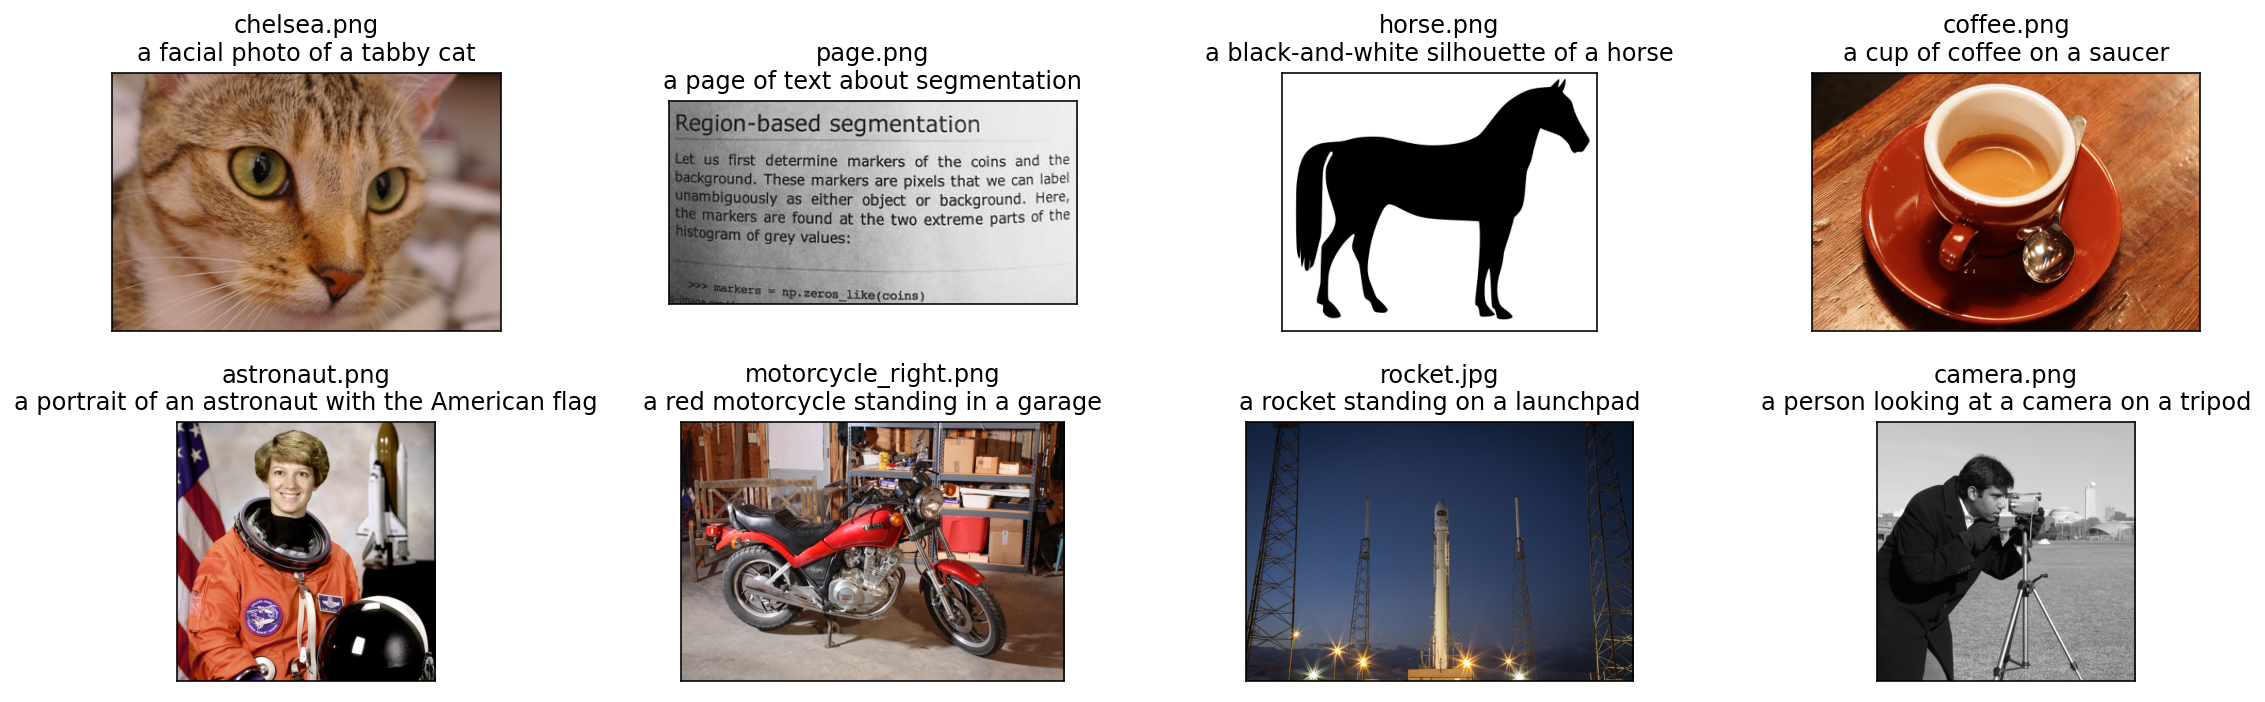

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

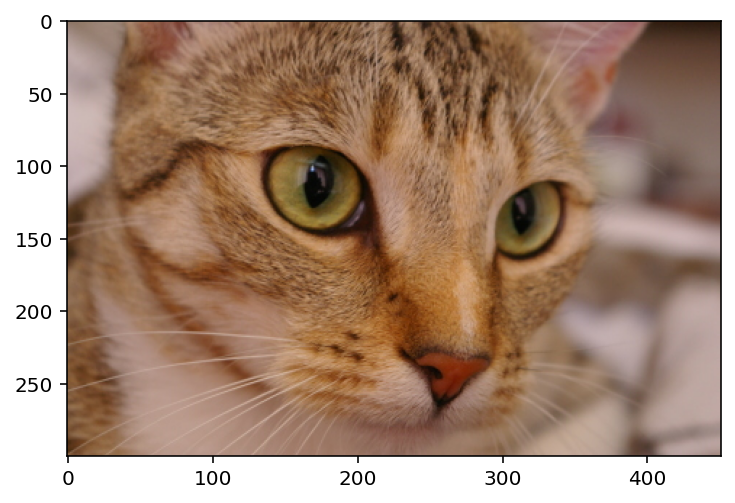

In [57]:
plt.imshow(original_images[0])

In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [14]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [16]:
texts

['a facial photo of a tabby cat',
 'a page of text about segmentation',
 'a black-and-white silhouette of a horse',
 'a cup of coffee on a saucer',
 'a portrait of an astronaut with the American flag',
 'a red motorcycle standing in a garage',
 'a rocket standing on a launchpad',
 'a person looking at a camera on a tripod']

In [17]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [18]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

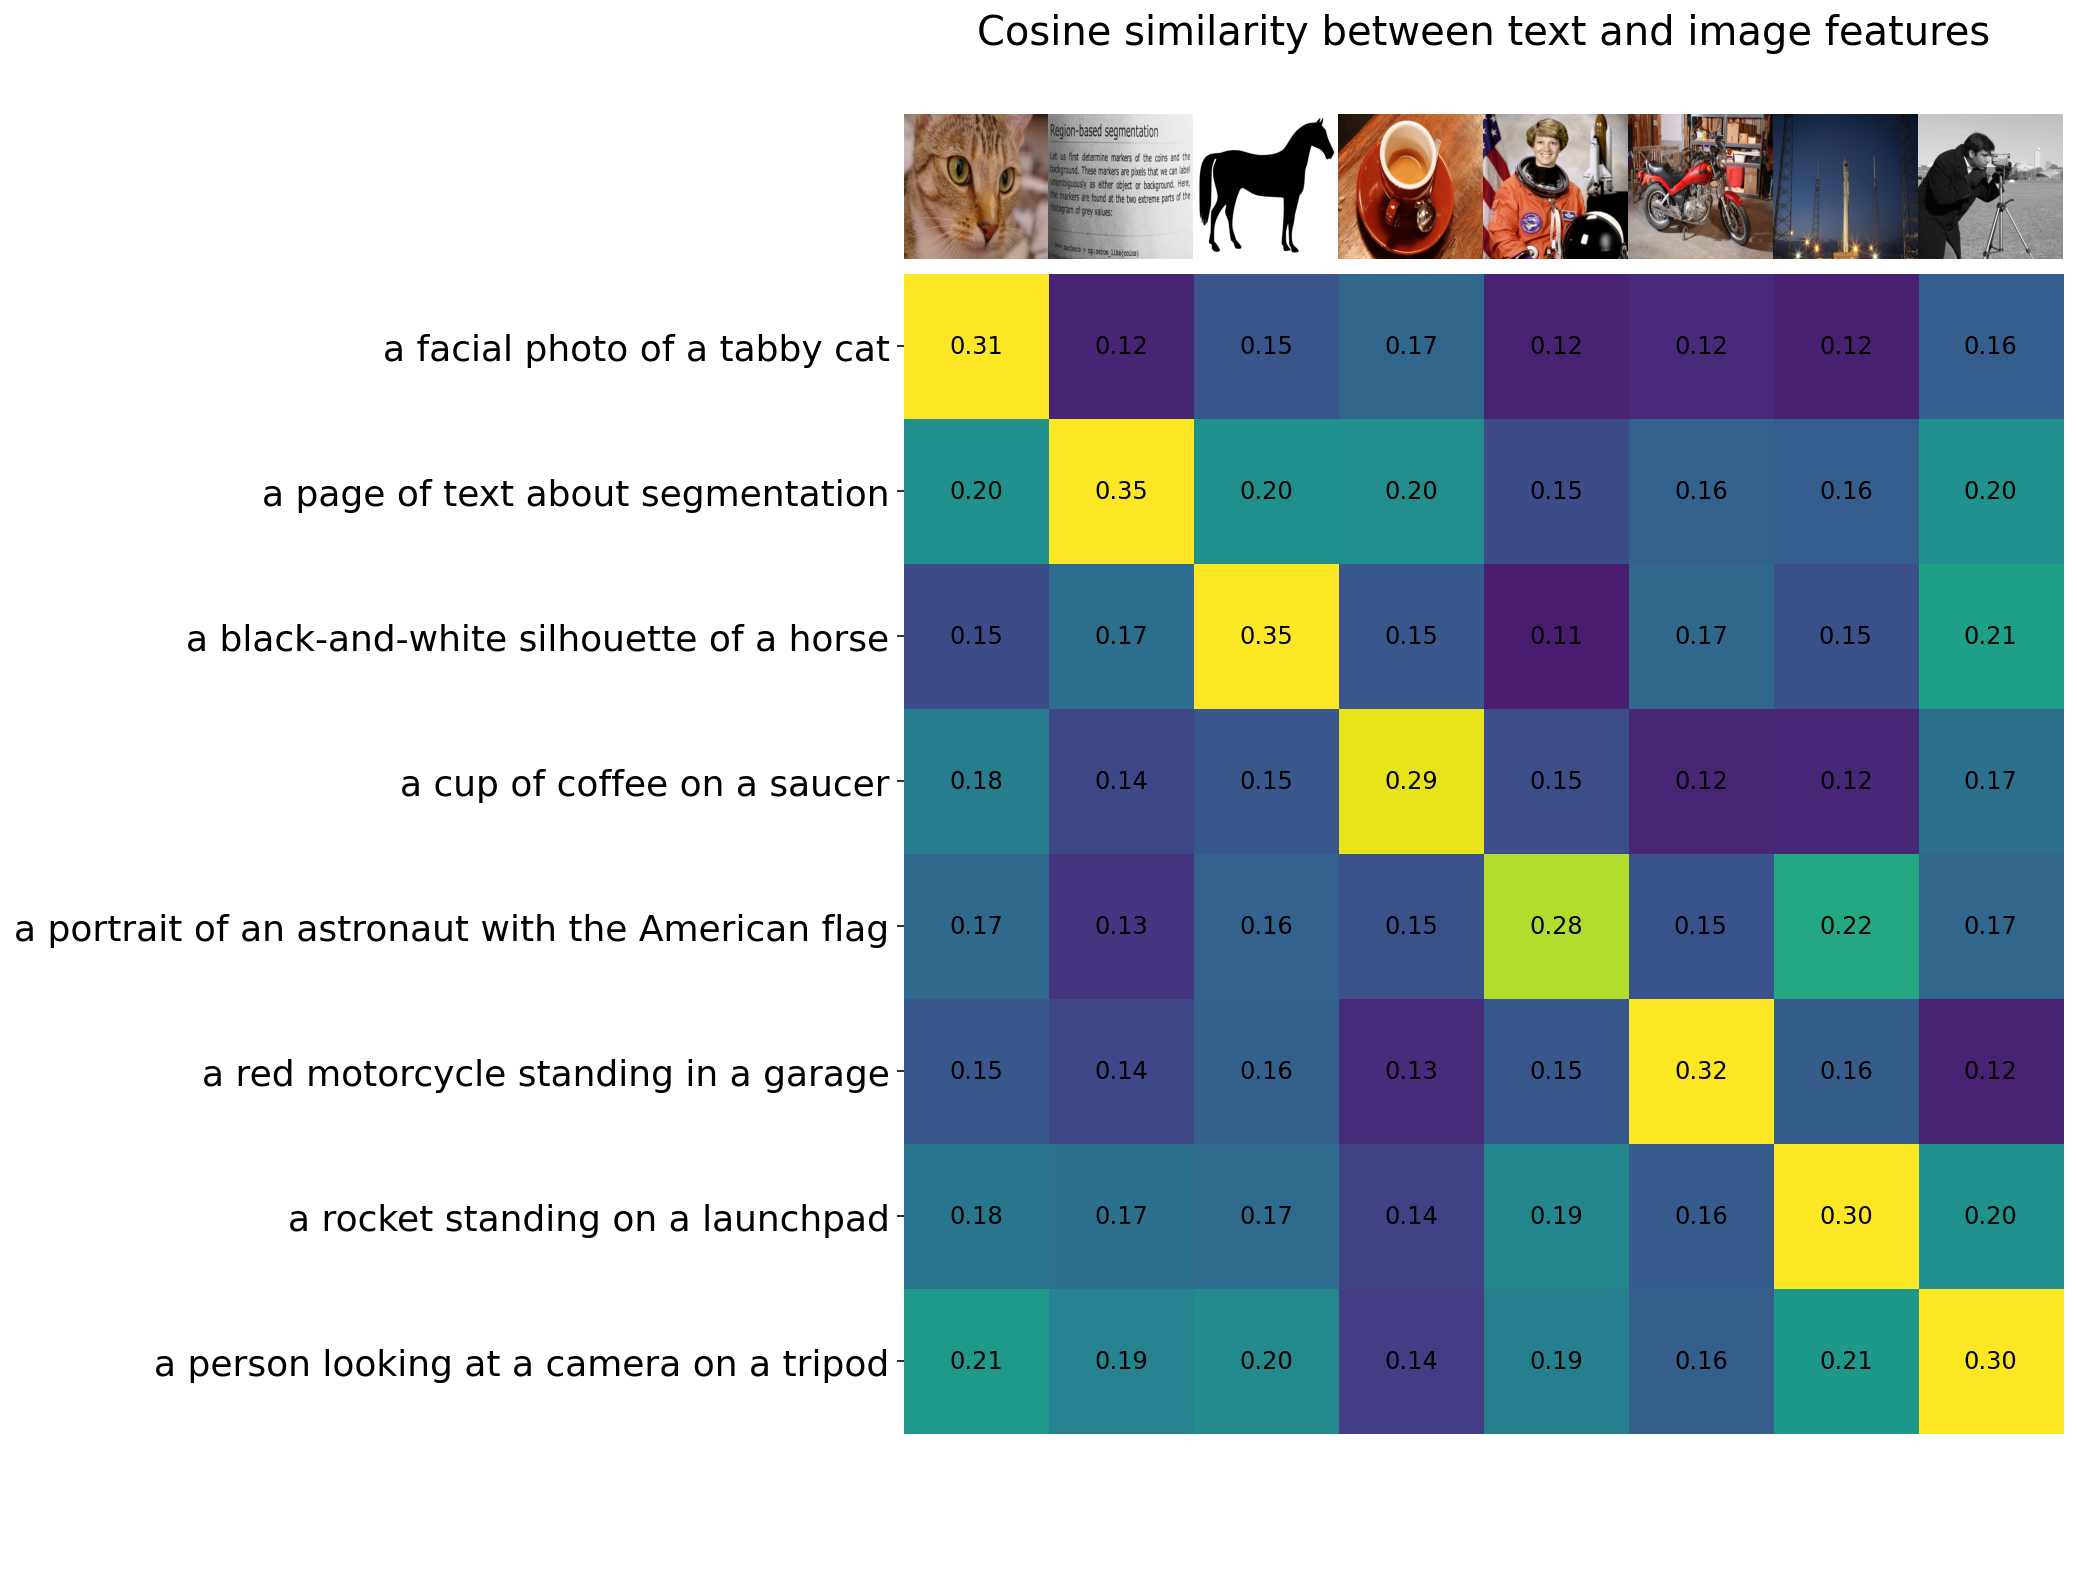

In [20]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Testing on Youcook2

In [21]:
## Testing on my dataset


!python -m pip install pytube

     |████████████████████████████████| 56 kB 3.5 MB/s 


In [24]:

link = "https://www.youtube.com/watch?v=GLd3aX16zBg"
from pytube import YouTube


yt = YouTube(link)


<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="12fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">

In [35]:
yt.streams.filter(progressive=True,file_extension='mp4').order_by('resolution').first()

<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">

In [113]:
import cv2
path = '/content/Grilled Cheese Recipe - How to make a White Trash Grilled Cheese Sandwich.mp4'
cap = cv2.VideoCapture(path)

In [110]:
start = 90
end = 102
times = range(start,end)
select_frames = [t*30 for t in times]
select_frames = set(select_frames)

In [111]:
start = 30
end = 40

times = range(start,end)
select_frames_adv = [t*30 for t in times]
select_frames_adv = set(select_frames_adv)

In [114]:
import matplotlib.pyplot as plt
main_frame = []
adv_frame = []


max_size = 50
i = 1
while True:
  ret,frame = cap.read()
  #
  if i in select_frames:
    main_frame.append(frame)
  elif i in select_frames_adv:
    adv_frame.append(frame)
  else:
    pass
  i += 1

  if not ret:
    break

(360, 640, 3)

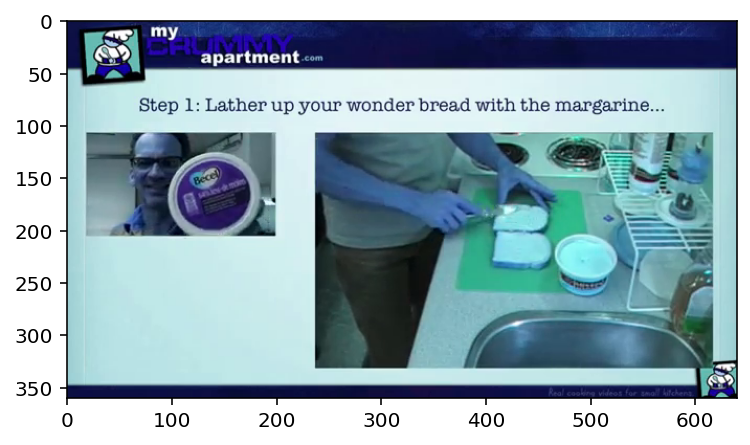

In [125]:
plt.imshow(main_frame[-4])

In [126]:


texts = ["spread margarine on two slices of white bread"]

text_tokens = clip.tokenize(texts).cuda()


up_main_frame = []
up_adv_frame = []
for im in main_frame:
  reord_im = im[:, :, [2, 1, 0]]
  reord_im = Image.fromarray(reord_im)
  up_main_frame.append(preprocess(reord_im))

for im in adv_frame:
  reord_im = im[:, :, [2, 1, 0]]
  reord_im = Image.fromarray(reord_im)
  up_adv_frame.append(preprocess(reord_im))

In [128]:
up_main_frame = torch.tensor(np.stack(up_main_frame)).cuda()
up_adv_frame = torch.tensor(np.stack(up_adv_frame)).cuda()


In [139]:
avg_frames = torch.stack([torch.mean(up_main_frame,axis=0),torch.mean(up_adv_frame,axis=0)])

In [129]:
with torch.no_grad():
    image_features = model.encode_image(up_main_frame).float()
    image_features_adv = model.encode_image(up_adv_frame).float()
    text_features = model.encode_text(text_tokens).float()

In [130]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [131]:
similarity

array([[0.182446  , 0.26888278, 0.29488984, 0.2934225 , 0.28426754,
        0.2928778 , 0.29159942, 0.3006464 , 0.29705927, 0.29399714,
        0.2987864 , 0.28204364]], dtype=float32)

In [134]:
image_features_adv /= image_features_adv.norm(dim=-1, keepdim=True)
#text_features /= text_features.norm(dim=-1, keepdim=True)
similarity_adv = text_features.cpu().numpy() @ image_features_adv.cpu().numpy().T

In [135]:
similarity_adv

array([[0.22718507, 0.233379  , 0.19836204, 0.19678122, 0.19521892,
        0.18848877, 0.19100557, 0.19557488, 0.21443309, 0.21372613]],
      dtype=float32)

In [140]:
with torch.no_grad():
    image_features_n = model.encode_image(avg_frames).float()
    #image_features_adv = model.encode_image(up_adv_frame).float()
    #text_features = model.encode_text(text_tokens).float()

In [143]:
image_features_n /= image_features_n.norm(dim=-1, keepdim=True)
#text_features /= text_features.norm(dim=-1, keepdim=True)
similarity_n = text_features.cpu().numpy() @ image_features_n.cpu().numpy().T

In [144]:
similarity_n

array([[0.28739643, 0.23040539]], dtype=float32)

We can note that almost all the values of `image_features_adv` are lower than `image_features`. Moreover averaging at the frame level is also working fine.

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

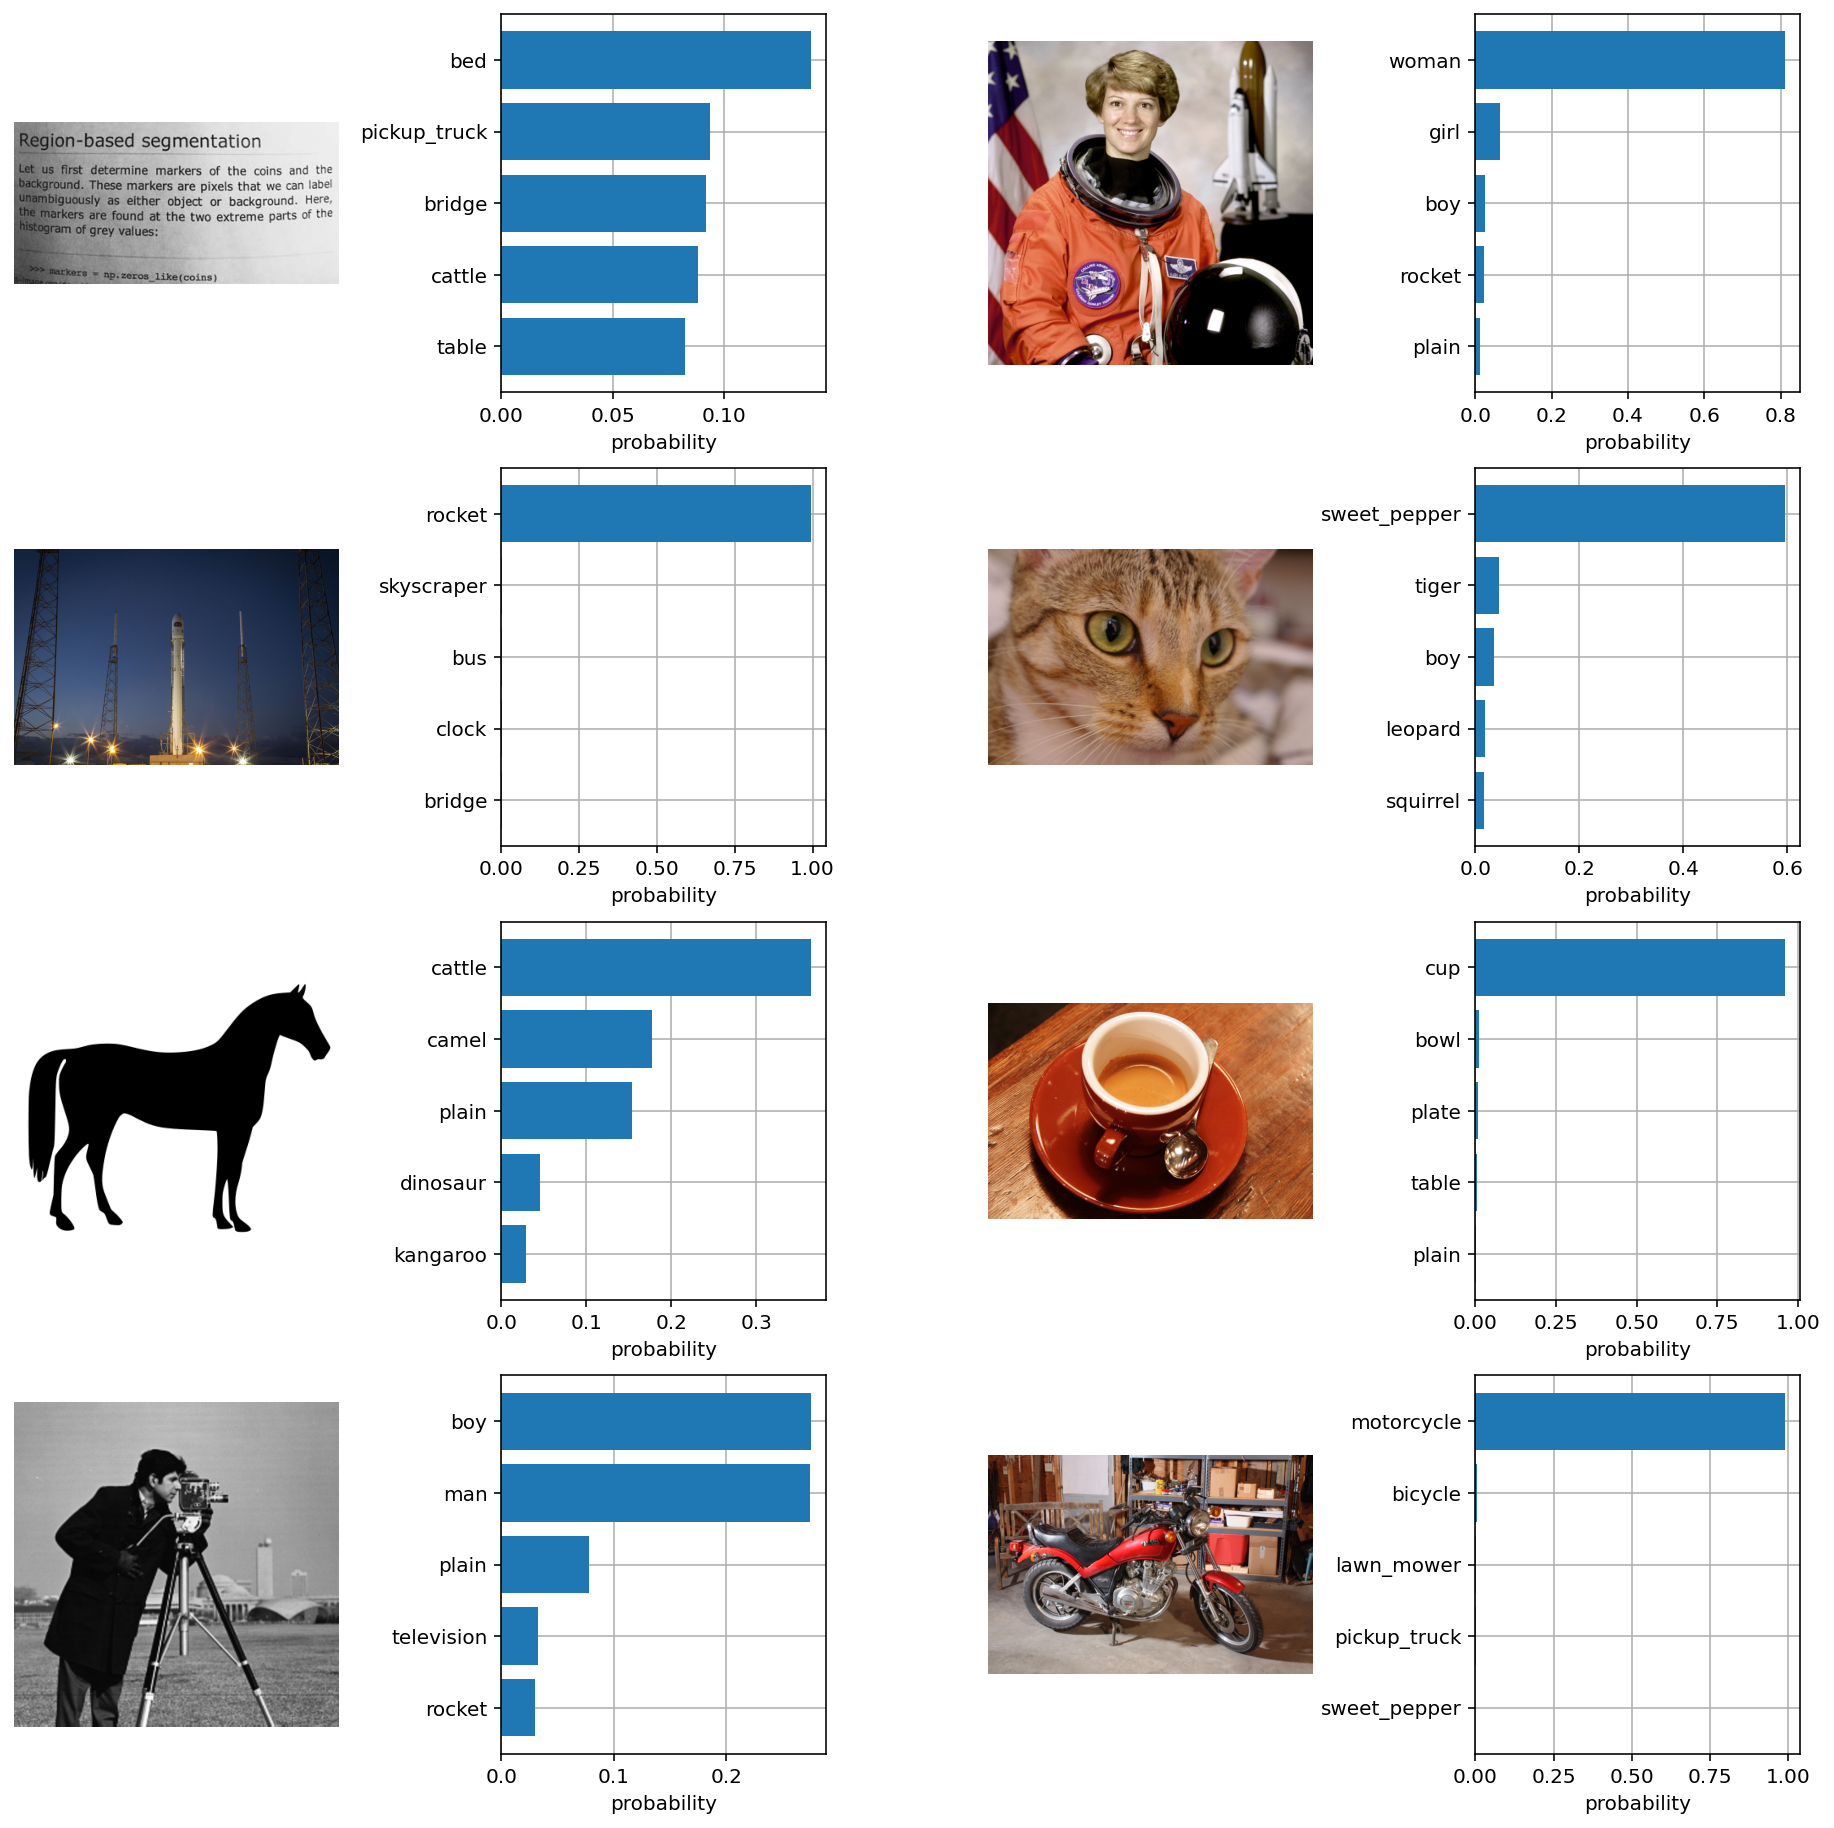

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()